In [448]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
#tf.config.optimizer.set_jit(False)
from tensorflow import keras
from keras.models import load_model
import random
from sklearn.metrics import mean_absolute_error
#import matplotlib
import os
import pickle

from keras.constraints import Constraint
from keras.layers import Layer
from keras import backend as K

import jax
import jax.nn as nn
from jax.random import normal
from jax.experimental import sparse
#from sparse import bcoo_concatenate
from jax.tree_util import tree_map
import jaxlib
import jax.numpy as jnp
import haiku as hk
import optax
from jax import jit
from functools import partial
import functools
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import csr_matrix
from optax import GradientTransformation

from utils import constrained_gradients, StateProbBound, StateProbFolded, Between, between
from linear import custom_linear
from training import model_training, shuffle_weights

In [235]:
%load_ext autoreload
%autoreload 2

# Define arguments

In [363]:
data_train = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_train.txt'
data_valid = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_valid.txt' 
data_obs = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_all.txt' 
o = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p/ '
e = 100 
l1_regularization_factor = 0 
l2_regularization_factor = 0 
p = 1000 
num_samples= 128,256,512,1024 
learning_rate= 0.001 
num_resamplings= 10 
num_models= 1 
random_seed= 1


In [364]:
args = {
    "data_train": "'/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_train.txt'",
    "data_valid": "/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_valid.txt",
    "data_obs": "/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_all.txt",
    "output_directory": "/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p/",
    "number_additive_traits": 1,
    "l1_regularization_factor": "0.0001,0.001,0.01,0.1",
    "l2_regularization_factor": "0.0001,0.001,0.01,0.1",
    "num_epochs_grid": 10,
    "num_epochs": 10,
    "num_samples": "128,256,512,1024",
    "learning_rate": "0.0001,0.001,0.01,0.1",
    "num_resamplings": 10,
    "early_stopping": False,
    "num_models": 2,
    "random_seed": 1
}

data_train_file = args["data_train"]
data_valid_file = args["data_valid"]
data_obs_file = args["data_obs"]
output_directory = args["output_directory"]
number_additive_traits = args["number_additive_traits"]
num_epochs_grid = args["num_epochs_grid"]
num_epochs = args["num_epochs"]
num_resamplings = args["num_resamplings"]
early_stopping = args["early_stopping"]
num_models = args["num_models"]
random_seed = args["random_seed"]

#Grid search arguments
l1 = [float(i) for i in args["l1_regularization_factor"].split(",")]
l2 = [float(i) for i in args["l2_regularization_factor"].split(",")]
batch_size = [int(i) for i in args["num_samples"].split(",")]
learn_rate = [float(i) for i in args["learning_rate"].split(",")]

# Load model data jax

In [365]:
def load_model_data_jax(file_dict):
    data_dict = {}
    for name in file_dict.keys():
        # Initialize
        data_dict[name] = {}

        # Read the entire file once
        df = pd.read_csv(file_dict[name])

        # Column names
        ALL_COLUMNS = list(df.columns)
        SELECT_COLUMNS = [col for col in ALL_COLUMNS if col.startswith("dataset_")]
        FOLD_COLUMNS = [col for col in ALL_COLUMNS if col.startswith("fold_") or col == "WT"]
        BIND_COLUMNS = [col for col in ALL_COLUMNS if col.startswith("bind_") or col == "WT"]
        TARGET_COLUMN = "fitness"
        TARGET_SD_COLUMN = "fitness_sd"
        SEQUENCE_COLUMN = "variant_sequence"
        TRAINING_SET_COLUMN = "training_set"

        # Save (sparse) tensors
        data_dict[name]["select"] = jnp.array(df[SELECT_COLUMNS], dtype=jnp.float32)
        data_dict[name]["fold"] = jnp.array(df[FOLD_COLUMNS], dtype=jnp.float32)
        data_dict[name]["bind"] = jnp.array(df[BIND_COLUMNS], dtype=jnp.float32)
        data_dict[name]["target"] = jnp.array(df[TARGET_COLUMN], dtype=jnp.float32)
        data_dict[name]["target_sd"] = jnp.array(df[TARGET_SD_COLUMN], dtype=jnp.float32)

        # Save remaining columns
        if SEQUENCE_COLUMN in df.columns:
            data_dict[name]["sequence"] = np.array(df[SEQUENCE_COLUMN].values)
        if TRAINING_SET_COLUMN in df.columns:
            data_dict[name]["training_set"] = jnp.expand_dims(jnp.array(df[TRAINING_SET_COLUMN].values), axis=-1)

        data_dict[name]["fold_colnames"] = np.array([col.replace("fold_", "") for col in FOLD_COLUMNS])
        data_dict[name]["bind_colnames"] = np.array([col.replace("bind_", "") for col in BIND_COLUMNS])

    return data_dict

In [459]:
data_train_file = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_train.txt'

data_valid_file = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_valid.txt' 

data_obs_file = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_all.txt'

In [462]:
#create the rng
random_seed = 42
rng = jax.random.PRNGKey(random_seed)

#Load model data
model_data_jax = load_model_data_jax({
    "train": data_train_file,
    "valid": data_valid_file,
    "obs": data_obs_file
    })

In [368]:
model_data_jax['train']

{'select': DeviceArray([[0., 1.],
              [0., 1.],
              [1., 0.],
              ...,
              [1., 0.],
              [1., 0.],
              [0., 1.]], dtype=float32),
 'fold': DeviceArray([[1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              ...,
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'bind': DeviceArray([[1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              ...,
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'target': DeviceArray([-0.33598602, -0.8518485 , -1.0957463 , ..., -0.26487023,
              -1.166961  , -0.66433465], dtype=float32),
 'target_sd': DeviceArray([0.11158013, 0.172

In [461]:
from utils import constrained_gradients, StateProbBound, StateProbFolded, Between, between, get_seq_id, get_layer_index
from training import model_training, shuffle_weights, fit_model_grid_jax
from dataloading import load_model_data_jax, resample_training_data_jax

# Resample training data jax

In [369]:
def resample_training_data_jax(tensor_dict, n_resamplings, rng):
    # Resample observed fitness from error distribution

    observed_fitness = tensor_dict["target"]
    observed_fitness_sd = tensor_dict["target_sd"]

    observed_fitness_resample = jnp.array(
    [jnp.array(
      [observed_fitness[i]+(observed_fitness_sd[i] * jax.random.normal(rng, shape=(1,))) for i in range(len(observed_fitness))])
    for j in range(n_resamplings)]
    )
    print('here')
    #Save new data

    tensor_dict["target"] = jax.device_put(jnp.expand_dims(observed_fitness_resample.ravel(), -1))

    select_tensors = [tensor_dict["select"] for i in range(n_resamplings)]  # Assuming n_resamplings is defined
    tensor_dict["select"] = jnp.concatenate(select_tensors, axis=0)

    fold_matrices = [tensor_dict["fold"] for i in range(n_resamplings)]
    tensor_dict["fold"] = jnp.concatenate(fold_matrices, axis=0)

    bind_matrices = [tensor_dict["bind"] for i in range(n_resamplings)]
    tensor_dict["bind"] = jnp.concatenate(bind_matrices, axis=0)

    return tensor_dict

In [370]:
#Resample training data
num_resamplings = 1

#create the rng
random_seed = 42
rng = jax.random.PRNGKey(random_seed)

if num_resamplings!=0:
    model_data_jax["train"] = resample_training_data_jax(
        tensor_dict = model_data_jax["train"],
        n_resamplings = num_resamplings,
        rng = rng)

here


In [463]:
model_data_jax["train"]

{'select': DeviceArray([[0., 1.],
              [0., 1.],
              [1., 0.],
              ...,
              [1., 0.],
              [1., 0.],
              [0., 1.]], dtype=float32),
 'fold': DeviceArray([[1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              ...,
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'bind': DeviceArray([[1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              ...,
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'target': DeviceArray([-0.33598602, -0.8518485 , -1.0957463 , ..., -0.26487023,
              -1.166961  , -0.66433465], dtype=float32),
 'target_sd': DeviceArray([0.11158013, 0.172

# Shuffle Weights

In [400]:
def shuffle_weights(rng, params):
    def _shuffle_array(rng, arr):
        flat_arr = arr.ravel()
        shuffled_flat_arr = jax.random.permutation(rng, flat_arr)
        return jnp.reshape(shuffled_flat_arr, arr.shape)
    
    leaves, _ = jax.tree_util.tree_flatten(params)
    rngs = jax.random.split(rng, len(leaves))
    new_params = jax.tree_util.tree_map(_shuffle_array, rngs, params)
    return new_params

# Create model Jax

In [372]:
def create_model_fn(number_additive_traits, l1, l2, rng):

    def model_fn(inputs_select, inputs_folding, inputs_binding):

        input_layer_select_folding = jnp.expand_dims(inputs_select[:, 0], -1)
        input_layer_select_binding = jnp.expand_dims(inputs_select[:, 1], -1)

        folding_additive_trait_layer = hk.Linear(number_additive_traits,
                                                 w_init=hk.initializers.VarianceScaling(1.0, "fan_avg",
                                                                                        "truncated_normal"),
                                                 with_bias=False
                                                 )(inputs_folding)

        folding_nonlinear_layer = StateProbFolded()(folding_additive_trait_layer)

        folding_additive_layer = hk.Linear(number_additive_traits,
                                           w_init=hk.initializers.VarianceScaling(1.0, "fan_avg", "truncated_normal"),
                                           with_bias=False  # ,
                                           # kernel_regularizer=hk.regularizers.L1L2(l1=l1, l2=l2)
                                           )(folding_nonlinear_layer)

        # binding
        binding_additive_trait_layer = hk.Linear(number_additive_traits,
                                                 w_init=hk.initializers.VarianceScaling(1.0, "fan_avg",
                                                                                        "truncated_normal"),
                                                 with_bias=False
                                                 )(inputs_binding)

        binding_nonlinear_layer = StateProbBound()(binding_additive_trait_layer, folding_additive_trait_layer)

        binding_additive_layer = hk.Linear(number_additive_traits,
                                           w_init=hk.initializers.VarianceScaling(1.0, "fan_avg", "truncated_normal"),
                                           with_bias=False
                                           )(binding_nonlinear_layer)

        # output
        multiplicative_layer_folding = folding_additive_layer * input_layer_select_folding
        multiplicative_layer_binding = binding_additive_layer * input_layer_select_binding
        output_layer = multiplicative_layer_folding + multiplicative_layer_binding

        return output_layer

    return model_fn


def create_model_jax(rng, learn_rate, l1, l2, input_dim_select, input_dim_folding, input_dim_binding,
                     number_additive_traits):
    # Create model
    model_fn = create_model_fn(number_additive_traits, l1, l2, rng)
    model = hk.without_apply_rng(hk.transform(model_fn))

    # Create optimizer
    opt = optax.chain(
        optax.adam(learn_rate),
        constrained_gradients(['folding_additive', 'binding_additive'], 0, 1e3),
    )

    # Create regularizer
    # regularizer = hk.regularizers.L1L2(l1=l1, l2=l2)

    return model, opt

# Grid Search Jax

In [453]:
def generate_batches(input_data, batch_size, rng):
    """Generate batches for training.

    Args:
        input_data: A dictionary of NumPy arrays containing the input data.
        batch_size: The batch size.
        rng: A JAX PRNGKey.

    Yields:
        A tuple of (select, fold, bind, target) batches.
    """
    num_samples = input_data['select'].shape[0]
    indices = jnp.arange(num_samples)

    # Shuffle the training data.
    rng, _ = jax.random.split(rng)
    indices = jax.random.permutation(rng, indices)

    # Generate batches.
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]

        batch_select = input_data['select'][batch_indices]
        batch_fold = input_data['fold'][batch_indices]
        batch_bind = input_data['bind'][batch_indices]
        batch_target = input_data['target'][batch_indices]

        yield batch_select, batch_fold, batch_bind, batch_target
        
def fit_model_grid_jax(param_dict, input_data, n_epochs, rng):
    # Summarize results
    print("Grid search using %s" % (param_dict))

    rng_init, rng_batches = jax.random.split(rng)

    # Create model
    model, optimizer = create_model_jax(
        rng=rng_init,
        learn_rate=param_dict['learning_rate'],
        l1=param_dict['l1_regularization_factor'],
        l2=param_dict['l2_regularization_factor'],
        input_dim_select=input_data['train']['select'].shape[1],
        input_dim_folding=input_data['train']['fold'].shape[1],
        input_dim_binding=input_data['train']['bind'].shape[1],
        number_additive_traits=param_dict['number_additive_traits'])

    @jax.jit
    def loss_fn(params, inputs_select, inputs_folding, inputs_binding, target):
        output = model.apply(params, inputs_select, inputs_folding, inputs_binding)
        loss = jnp.mean(jnp.abs(output - target))

        # Apply L1 and L2 regularization
        l1_loss = 0
        l2_loss = 0
        for p in jax.tree_util.tree_leaves(params):
            if p.ndim > 1:  # exclude bias parameters
                l1_loss += jnp.sum(jnp.abs(p))
                l2_loss += jnp.sum(jnp.square(p))
        loss = loss + param_dict['l1_regularization_factor'] * l1_loss + param_dict[
            'l2_regularization_factor'] * l2_loss

        return loss

    @jax.jit
    def update(params, opt_state, inputs_select, inputs_folding, inputs_binding, target):
        grads = jax.grad(loss_fn)(params, inputs_select, inputs_folding, inputs_binding, target)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        # print('update done')
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state

    params = model.init(rng, input_data['train']['select'], input_data['train']['fold'], input_data['train']['bind'])
    opt_state = optimizer.init(params)

    for epoch in range(n_epochs):
        for batch_data in generate_batches(input_data['train'], param_dict['num_samples'], rng_batches):
            inputs_select, inputs_folding, inputs_binding, target = batch_data
            params, opt_state = update(params, opt_state, inputs_select, inputs_folding, inputs_binding, target)
        val_loss = loss_fn(params, input_data['valid']['select'], input_data['valid']['fold'],
                           input_data['valid']['bind'], input_data['valid']['target'])
        print('epoch done')

    return val_loss.item()

In [456]:
from training import fit_model_grid_jax

In [464]:
#Fit model
if len(l1) == 1 and len(l2) == 1 and len(batch_size) == 1 and len(learn_rate) == 1:
    best_params = {
        "num_samples": batch_size[0],
        "learning_rate": learn_rate[0],
        "l1_regularization_factor": l1[0],
        "l2_regularization_factor": l2[0],
        "number_additive_traits": 1
    }
else:
    parameter_grid = [{
        "num_samples": i,
        "learning_rate": j,
        "l1_regularization_factor": k,
        "l2_regularization_factor": l,
        "number_additive_traits": 1
    } for i in batch_size for j in learn_rate for k in l1 for l in l2]

    rng = jax.random.PRNGKey(random_seed)
    rngs = jax.random.split(rng, len(parameter_grid[:3]))
    #print(len(parameter_grid))
    grid_results = [fit_model_grid_jax(params, model_data_jax, num_epochs_grid, rng_key) for params, rng_key in zip(parameter_grid, rngs)]

    best_params = parameter_grid[np.argmin(grid_results)]

    print("Best: %f using %s" % (min(grid_results), best_params))

num_samples = best_params['num_samples']
learning_rate = best_params['learning_rate']
l1_regularization_factor = best_params['l1_regularization_factor']
l2_regularization_factor = best_params['l2_regularization_factor']


Grid search using {'num_samples': 128, 'learning_rate': 0.0001, 'l1_regularization_factor': 0.0001, 'l2_regularization_factor': 0.0001, 'number_additive_traits': 1}


/Users/pierredemetz/miniconda3/envs/pierre/lib/python3.8/site-packages/haiku/_src/data_structures.py:143: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/Users/pierredemetz/miniconda3/envs/pierre/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
Grid search using {'num_samples': 128, 'learning_rate': 0.0001, 'l1_regularization_factor': 0.0001, 'l2_regularization_factor': 0.001, 'number_additive_traits': 1}
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
Grid search using {'num_samples': 128, 'learning_rate': 0.0001, 'l1_regularization_factor': 0.0001, 'l2_regularization_factor': 0.01, 'number_additive_traits': 1}
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
Best: 0.427219 using {'num_samples': 128, 'learning_rate': 0.0001, 'l1_regularization_factor': 0.0001, 'l2_regularization_factor': 0.01, 'number_additive_traits': 1}


# Fitting final model and testing

In [465]:
#Output model directory
model_directory = os.path.join(output_directory, "whole_model")
#Create output model directory
try:
  os.mkdir(model_directory)
except FileExistsError:
  print("Warning: Output model directory already exists.")

#Output plot directory
plot_directory = os.path.join(output_directory, "plots")
#Create output plot directory
try:
  os.mkdir(plot_directory)
except FileExistsError:
  print("Warning: Output plot directory already exists.")

In [449]:
from training import model_training, shuffle_weights

Grid search using {'num_samples': 128, 'learning_rate': 0.0001, 'l1_regularization_factor': 0.0001, 'l2_regularization_factor': 0.01, 'number_additive_traits': 1}
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
[0.6976140141487122, 0.6637396812438965, 0.6319745779037476, 0.602327823638916, 0.5750360488891602, 0.5503971576690674, 0.5282517671585083, 0.5083247423171997, 0.48985135555267334, 0.47273972630500793]


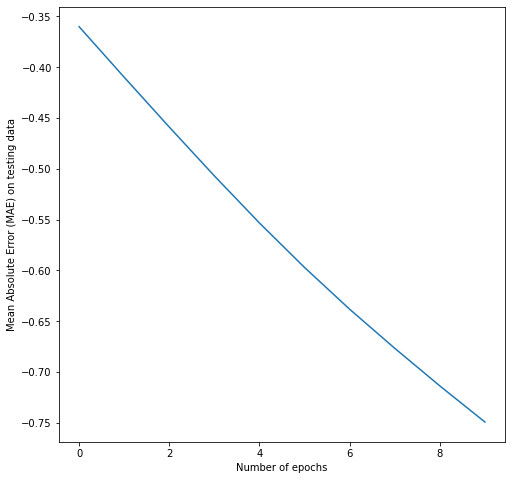

Grid search using {'num_samples': 128, 'learning_rate': 0.0001, 'l1_regularization_factor': 0.0001, 'l2_regularization_factor': 0.01, 'number_additive_traits': 1}


/Users/pierredemetz/miniconda3/envs/pierre/lib/python3.8/site-packages/haiku/_src/data_structures.py:143: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/Users/pierredemetz/miniconda3/envs/pierre/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


epoch done


KeyboardInterrupt: 

In [466]:
num_samples = best_params['num_samples']
learning_rate = best_params['learning_rate']
l1_regularization_factor = best_params['l1_regularization_factor']
l2_regularization_factor = best_params['l2_regularization_factor']
number_additive_traits = best_params['number_additive_traits']

#######################################################################
## BUILD FINAL NEURAL NETWORK ##
#######################################################################

#create the rng
random_seed = 42
rng = jax.random.PRNGKey(random_seed)
num_models = 2 

model, optimizer = create_model_jax(
    rng=rng,
    learn_rate=learning_rate,
    l1=l1_regularization_factor,
    l2=l2_regularization_factor,
    input_dim_select=model_data_jax['train']['select'].shape[1],
    input_dim_folding=model_data_jax['train']['fold'].shape[1],
    input_dim_binding=model_data_jax['train']['bind'].shape[1],
    number_additive_traits=number_additive_traits
)

weights = model.init(rng, model_data_jax['train']['select'], model_data_jax['train']['fold'], model_data_jax['train']['bind'])
opt_state = optimizer.init(weights)

for model_count in range(num_models):

    #Shuffle model weights
    shuffled_weights = shuffle_weights(rng, weights)

    #Fit the model on best params
    history, model = model_training(model, optimizer, shuffled_weights, opt_state, best_params, model_data_jax, num_epochs_grid, rng)
    
    #save model
    #model.save(os.path.join(model_directory, 'my_model_'+str(model_count)))
    with open(f'weights_{model_count}.pickle', 'wb') as handle:
        pickle.dump(shuffled_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    #load model
    #model = load_model(os.path.join(model_directory, 'my_model_'+str(model_count)))
    with open(f'weights_{model_count}.pickle', 'rb') as handle:
        shuffled_weights_reloaded = pickle.load(handle)
        
    print(history)
    #Plot model performance per epoch
    my_figure = plt.figure(figsize = (8,8))
    plt.plot(np.log(history))
    plt.xlabel('Number of epochs')
    plt.ylabel('Mean Absolute Error (MAE) on testing data')
    plt.show()
    my_figure.savefig(os.path.join(plot_directory, "model_performance_perepoch_"+str(model_count)+".pdf"), bbox_inches='tight')
    
    #######################################################################
    ## SAVE OBSERVATIONS, PREDICTIONS & ADDITIVE TRAIT VALUES ##
    #######################################################################
    
